In [68]:
import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from tqdm import tqdm
import torchmetrics
from torchmetrics import AUROC
from tab_transformer_pytorch import TabTransformer
import matplotlib.pyplot as plt
import gc, sys, random, warnings
gc.enable()
warnings.filterwarnings("ignore")

In [69]:
torchmetrics.__version__

'1.3.1'

In [70]:
pd.set_option('display.max_columns',1000)

In [71]:
torch.__version__

'1.11.0'

In [72]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
seed_all(123)

In [73]:
# Load data
path = './Backup_Regression/'
name = 'Predictions_Option_1.xlsx'

data = pd.read_excel(path+name)
print(data.shape)

(738, 39)


In [74]:
# bmi_original_columns = [col for col in data.columns if 'Body mass index' in col and 'after surgery' in col and 'predicted' not in col]
post_surgery_columns = [col for col in data.columns if 'after surgery' in col and 'predicted' not in col and 'Diabetes Mellitus' not in col]
print(post_surgery_columns)

# Drop the bmi post surgery (original) columns, since a lot of them have mising values
cols_to_drop = post_surgery_columns + ['record_id','redcap_data_access_group']
print(f'Dropping {len(cols_to_drop)} columns...')
data = data.drop(columns=cols_to_drop)
#print('Adding a sample weight column..')
#data['sample_weight'] = 1
print(data.shape)

data.columns = [col.strip() for col in data.columns]

data4 = data.copy()
data5 = data4[(data4['Diabetes Mellitus 3 months after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 6 months after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 12 months after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 18 months after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 2 years after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 3 years after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 4 years after surgery (1 = Yes\n2 = No)'].isnull() == False)&(data4['Diabetes Mellitus 5 years after surgery (1 = Yes\n2 = No)'].isnull() == False)].copy()
data6 = data4.loc[~data4.index.isin(data5.index.tolist())]
print(data4.shape, data5.shape, data6.shape)

# Split the data in train and validation and then, for train data, perform the KFold Cross Validation
target_columns = ['Diabetes Mellitus 3 months after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 6 months after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 12 months after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 18 months after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 2 years after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 3 years after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 4 years after surgery (1 = Yes\n2 = No)',
                 'Diabetes Mellitus 5 years after surgery (1 = Yes\n2 = No)']

Y = data5[target_columns].copy()
# Replace 2's in Y with 0's
Y = Y.replace(2,0)
X = data5.drop(columns = target_columns).copy()
X1 , X_val , Y1 , Y_val = train_test_split(X ,
                                           Y,
                                           test_size = 0.2,
                                           random_state = 1234)

print(X1.shape, Y1.shape, X_val.shape, Y_val.shape)

# train_data = pd.concat([X1,Y1],axis=1)
# test_data = pd.concat([X_val,Y_val],axis=1)
# print(train_data.shape, test_data.shape)


target_df = Y1
train_df = X1
#train_df['target'] = target_df.iloc[:,:1]
test_df = X_val
print(train_df.shape, target_df.shape, test_df.shape)

['Complication after surgery (1 = Anastomotic leakage\n2 = Sleeve leak\n3 = Intussusception after Roux-en-Y gastric bypass\n4 = Mesenteric internal hernia after Roux-en-Y gastric bypass\n5 = Internal hernia through Peterson`s defect after Roux-en-Y gastric bypass\n6 = Hiatal hernia\n7 = Gastro Esophageal Reflux Disease (GERD)\n8 = Amastomotic Ulcer\n9 = Anastomotic stricture\n10 = Hemorrhage\n11 = No Complication)', 'Body mass index 3 months after surgery', 'Body mass index 6 months after surgery', 'Body mass index 12 months after surgery', 'Body mass index 18 months after surgery', 'Body mass index 2 years after surgery', 'Body mass index 3 years after surgery', 'Body mass index 4 years after surgery', 'Body mass index 5 years after surgery']
Dropping 11 columns...
(738, 28)
(738, 28) (738, 28) (0, 28)
(590, 20) (590, 8) (148, 20) (148, 8)
(590, 20) (590, 8) (148, 20)


In [75]:
cat_cols = [
    'sex (1=Female\n2=Male)',
    'American Society of Anesthesiologists (ASA) Score (1 = ASA 1: healthy person\n2 = ASA 2: mild systemic disease\n3 = ASA 3: severe systemic disease\n4 =ASA 4: severe systemic disease that is a constant threat to life\n5 = ASA 5: a moribund person who is not expected to survive without the operation)',
    'Diabetes mellitus type II preoperative (1 = yes\n2 = No)',
    'Antidiabetic drugs preoperativ (1 = Orale Antidiabetic drugs\n2 = Insulin\n3 = No therapy)',
    'Obstructive sleep apnea syndrome (OSAS) preoperative  (1 = yes\n2 = No)',
    'surgery (1 = LSG (Laparoscopic Sleeve Gastrectomy)\n2 = RYGB (Roux en-Y Gastric Bypass)\n3 = SADI (single anastomosis duodeno-ileal bypass)\n4 = BPD-DS (Biliopancreatic diversion with duodenal switch)\n5 = OAGB (One-anastomosis Gastric Bypass)',
    'Conversion from gastric sleeve to gastric bypass (1 = Yes\n2 = No\n3 = Not available)',
    "Closure of Petersen's space (1 = Yes\n2 = No\n3 = Not available)",
    'Closure of the jejunojejunostomy defect (1 = Yes\n2 = No\n3 = Not available)'
]

cont_cols = list(set(train_df.columns)-set(cat_cols))

train_df = train_df[cont_cols+cat_cols]
test_df = test_df[cont_cols+cat_cols]

##### Converting numerical features into Normal Distributions

In [76]:
train_scaled, test_scaled = train_df.copy(), test_df.copy()
for col in cont_cols:
    transformer = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
    vec_len = len(train_scaled[col].values)
    vec_len_test = len(test_scaled[col].values)
    raw_vec = train_scaled[col].values.reshape(vec_len, 1)
    transformer.fit(raw_vec)

    train_scaled[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    test_scaled[col] = transformer.transform(test_scaled[col].values.reshape(vec_len_test, 1)).reshape(1, vec_len_test)[0]

In [77]:
del(train_df); del (test_df); gc.collect()

1262

##### Discretizing Continuous Features

In [78]:
disc = KBinsDiscretizer(n_bins=50, encode='ordinal',strategy='uniform')
train_scaled[cont_cols] = disc.fit_transform(train_scaled[cont_cols])
test_scaled[cont_cols] = disc.transform(test_scaled[cont_cols])

In [79]:
y_train = target_df.values
train_scaled = train_scaled.values
test_scaled = test_scaled.values

##### Computing the class weights for each of the labels

In [80]:
neg_label_weights = list(y_train.sum(axis=0)/y_train.shape[0])
pos_label_weights = list(1-(y_train.sum(axis=0)/y_train.shape[0]))

print(pos_label_weights)
print(neg_label_weights)

[0.9169491525423729, 0.9118644067796611, 0.8627118644067797, 0.9271186440677966, 0.8677966101694915, 0.9254237288135593, 0.9322033898305084, 0.9305084745762712]
[0.08305084745762711, 0.08813559322033898, 0.13728813559322034, 0.07288135593220339, 0.13220338983050847, 0.07457627118644068, 0.06779661016949153, 0.06949152542372881]


In [81]:
# target = torch.tensor([[1,0,1,1,0,0,0,0],[0,0,1,1,0,0,1,0]])

# target_size = target.shape[0]
# pos_weights = torch.tensor([pos_label_weights for i in range (0,target_size)])
# neg_weights = torch.tensor([neg_label_weights for i in range (0,target_size)])

# final_weights = target*pos_weights + (1-target)*neg_weights

# loss = (loss * final_weights).mean()

In [82]:
y_train.shape, train_scaled.shape, test_scaled.shape

((590, 8), (590, 20), (148, 20))

##### Utilities (Functions To Be Used in Training Stage)

In [83]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [84]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.001, verbose = None):
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.verbose = verbose
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):

        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
        elif score < self.best_score: #  + self.delta
            self.counter += 1
            if self.verbose:
                print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            if self.verbose:
                print('Validation score improved ({:.4f} --> {:.4f}). Saving model!'.format(self.val_score, epoch_score))
                
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

In [85]:
class TabDataset(Dataset):
    def __init__(self, cat, target = None):
        super().__init__()
        self.cat = cat
        self.target = target
        
    def __len__(self):
        return len(self.cat)
    
    def __getitem__(self, idx):
        cat = self.cat[idx]
        
        _dict = {'cont': torch.ones(1),
                 'cat': torch.LongTensor(cat)}
        
        if self.target is not None:
            target = self.target[idx]
            _dict.update({'target': torch.tensor(target, dtype = torch.float)})
        
        return _dict

In [86]:
class Trainer:
    def __init__(self, model, device, loss_fn, opt, scheduler = None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.opt = opt
        self.scheduler = scheduler
        
    def fit_one_epoch(self, dl):
        self.model.train()
        losses = AverageMeter()
        prog_bar = tqdm(enumerate(dl), total = len(dl), file=sys.stdout, leave = False)
        
        for bi, d in prog_bar:
            cont = d["cont"].to(self.device)
            cat = d['cat'].to(self.device)
            target = d['target'].to(self.device)
            #print('Target Type :',type(target))
            #print('Target Shape :',target.shape)
            out = self.model(cat, cont)
            target_size = target.shape[0]
            pos_weights = torch.tensor([pos_label_weights for i in range (0,target_size)])
            neg_weights = torch.tensor([neg_label_weights for i in range (0,target_size)])
            final_weights = target*pos_weights + (1-target)*neg_weights
            loss = self.loss_fn(out.squeeze(-1), target)
            loss = (loss * final_weights).mean()

            prog_bar.set_description('loss: {:.2f}'.format(loss.item()))
            losses.update(loss.item(), cont.size(0))
            loss.backward()
            self.opt.step()
            
            if self.scheduler: 
                self.scheduler.step()
                    
            self.opt.zero_grad()
            
    def eval_one_epoch(self, dl, **kwargs):
        self.model.eval()
        losses = AverageMeter()
        metric = AUROC(task='binary')
        prog_bar = tqdm(enumerate(dl), total = len(dl), file=sys.stdout, leave = False)
        
        for bi, d in prog_bar:  
            cont = d["cont"].to(self.device)
            cat = d['cat'].to(self.device)
            target = d['target'].to(self.device)
            #print('Target Type :',type(target))
            #print('Target Shape :',target.shape)
            
            with torch.no_grad():
                out = self.model(cat, cont)
                #print('Out :', out)
                target_size = target.shape[0]
                pos_weights = torch.tensor([pos_label_weights for i in range (0,target_size)])
                neg_weights = torch.tensor([neg_label_weights for i in range (0,target_size)])
                final_weights = target*pos_weights + (1-target)*neg_weights
                loss = self.loss_fn(out.squeeze(-1), target)
                loss = (loss * final_weights).mean()
                if metric:
                    auroc = metric(out.squeeze(-1), target.int())
                
                losses.update(loss.item(), cont.size(0))
        auroc = metric.compute()
        print(f"F{kwargs['fold']} E{str(kwargs['epoch']):2s}"\
              f"  Valid Loss: {losses.avg:.4f}  AUROC Score: {auroc:.4f}")
        return auroc.cpu() if metric else losses.avg

##### Training

In [87]:
class cfg:
    bs = 64
    n_splits = 5
    seed = 2021
    epochs = 3
    lr = 2e-5
    checkpoint = lambda fold: f'full_cat_{fold}.pt'
    
kfold = KFold(n_splits = cfg.n_splits, 
                        random_state = cfg.seed, 
                        shuffle = True)
splits = [*kfold.split(X = train_scaled, y = y_train[:,:1])]

In [88]:
len(cat_cols), len(cont_cols)

(9, 11)

In [89]:
# Configuration File For The Transformer Model
transformer_cfg = {
    'categories' : [50]*11 + [2, 5, 2, 3, 2, 5, 3, 3, 3],           # iterable with the number of unique values for categoric feature
    #'categories' : [2, 5, 2, 3, 2, 5, 3, 3, 3],           # iterable with the number of unique values for categoric feature
    'num_continuous' : 1,                       # continuous dimensions in data
    'dim' : 32,                                 # hidden dim, paper set at 32
    'dim_out' : 8,                              # binary prediction
    'depth' : 3,                                # depth, paper recommended 6
    'heads' : 6,                                # heads, paper recommends 8
    'attn_dropout' : 0.1,                       # post-attention dropout
    'ff_dropout' : 0.1,                         # feed forward dropout
    'mlp_hidden_mults' : (4, 2),                # relative multiples of each hidden dimension of the last mlp to logits
    'mlp_act' : nn.GELU(),                      # activation for final mlp, defaults to relu
    'continuous_mean_std' : torch.randn(1, 2)   # normalize the continuous values before layer norm (optional)
}

In [90]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [91]:
def create_dataloaders(fold):
    train_idx, valid_idx = splits[fold]
    
    _xtr, _ytr = train_scaled[train_idx], y_train[train_idx]
    _xval, _yval = train_scaled[valid_idx], y_train[valid_idx]
    
    train_ds = TabDataset(cat = _xtr, target = _ytr)
    valid_ds = TabDataset(cat = _xval, target = _yval)
                          
    train_dl = DataLoader(train_ds, batch_size = cfg.bs, shuffle = True)
    valid_dl = DataLoader(valid_ds, batch_size = cfg.bs, shuffle = False)
    
    return train_dl, valid_dl

In [92]:
def train_fold(fold, epochs = 20):
    train_dl, valid_dl = create_dataloaders(fold)
    es = EarlyStopping(patience = 7, mode="max", verbose = False)
    
    model = TabTransformer(**transformer_cfg).to(device)
    
    opt = torch.optim.AdamW(model.parameters(), lr = cfg.lr)

    trainer = Trainer(model, 
                      device, 
                      loss_fn=nn.BCEWithLogitsLoss(reduction='none'),
                      opt = opt,
                      scheduler = None,
                     )
    
    for epoch in range(epochs):
        trainer.fit_one_epoch(train_dl)
        valid_loss = trainer.eval_one_epoch(valid_dl, fold = fold, epoch = epoch)
        
        es(valid_loss, trainer.model, model_path = cfg.checkpoint(fold))       
        if es.early_stop:
            break

In [93]:
for fold in range(cfg.n_splits):
    train_fold(fold, cfg.epochs)
    torch.cuda.empty_cache()
    gc.collect()

F0 E0   Valid Loss: 0.1292  AUROC Score: 0.8384                                                                        
F0 E1   Valid Loss: 0.1250  AUROC Score: 0.9076                                                                        
F0 E2   Valid Loss: 0.1206  AUROC Score: 0.9234                                                                        
F1 E0   Valid Loss: 0.1134  AUROC Score: 0.8999                                                                        
F1 E1   Valid Loss: 0.1092  AUROC Score: 0.9628                                                                        
F1 E2   Valid Loss: 0.1047  AUROC Score: 0.9705                                                                        
F2 E0   Valid Loss: 0.1031  AUROC Score: 0.8219                                                                        
F2 E1   Valid Loss: 0.1004  AUROC Score: 0.9108                                                                        
F2 E2   Valid Loss: 0.0974  AUROC Score:

##### Prediction

In [94]:
y_pred = torch.zeros(len(test_scaled), 8).to(device)
test_ds = TabDataset(cat = test_scaled)
test_dl = DataLoader(test_ds, batch_size = cfg.bs, shuffle = False)

with torch.no_grad():
    for fold in range(cfg.n_splits):
        preds = []
        model = TabTransformer(**transformer_cfg).to(device)
        state_dict = cfg.checkpoint(fold)
        model.load_state_dict(torch.load(state_dict))
        model.eval()
        
        for d in test_dl:
            cont = d["cont"].to(device)
            cat = d['cat'].to(device)
            out = model(cat, cont)
            preds.append(out)
            
        preds = torch.vstack(preds)
        y_pred += preds / cfg.n_splits

In [95]:
y_pred.shape

torch.Size([148, 8])

In [96]:
torch.tensor(Y_val.values).shape

torch.Size([148, 8])

In [97]:
y_pred

tensor([[-0.1587, -0.2128, -0.3468,  ..., -0.1551, -0.2151, -0.1884],
        [-0.0839, -0.1505, -0.2217,  ..., -0.1650, -0.0868, -0.0847],
        [ 0.1742,  0.1485,  0.2849,  ...,  0.1535,  0.2121,  0.1243],
        ...,
        [ 0.0341,  0.0204,  0.1127,  ..., -0.0064,  0.0620,  0.0532],
        [-0.2065, -0.2354, -0.2638,  ..., -0.2214, -0.1984, -0.1847],
        [-0.0547, -0.0703, -0.1652,  ..., -0.0613, -0.0923, -0.0934]])

In [98]:
Y_val.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [138]:
# loss_fn=nn.BCEWithLogitsLoss()
# loss_fn(y_pred, torch.tensor(Y_val.values, dtype=torch.float32))
# nn.BCEWithLogitsLoss()

In [99]:
sigmoid = nn.Sigmoid()
y_hat = sigmoid(y_pred)

In [100]:
# Probability Distribution Of Predicted Values After Implementing Class Weights 
#(Improvement seen as we can now see probabilities above 0.5 as well)
pd.DataFrame(y_hat).describe()

,0,1,2,3,4,5,6,7
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.465104,0.465054,0.451313,0.473256,0.455960,0.465579,0.473946,0.469811
std,0.028255,0.030028,0.047466,0.023556,0.043253,0.025850,0.027500,0.026800
min,0.428590,0.421770,0.391763,0.442267,0.398878,0.431679,0.436410,0.432751
25%,0.445149,0.442642,0.415727,0.453519,0.424980,0.446716,0.453045,0.451770
50%,0.457332,0.458072,0.439245,0.468893,0.443194,0.459243,0.464806,0.460005
75%,0.480122,0.480462,0.469127,0.484076,0.475416,0.478161,0.487588,0.483059
max,0.559060,0.561300,0.607330,0.558433,0.597351,0.554342,0.566647,0.571141


In [109]:
y_hat = pd.DataFrame(y_hat)
y_hat.columns = Y_val.columns

In [110]:
y_hat

,Diabetes Mellitus 3 months after surgery (1 = Yes\n2 = No),Diabetes Mellitus 6 months after surgery (1 = Yes\n2 = No),Diabetes Mellitus 12 months after surgery (1 = Yes\n2 = No),Diabetes Mellitus 18 months after surgery (1 = Yes\n2 = No),Diabetes Mellitus 2 years after surgery (1 = Yes\n2 = No),Diabetes Mellitus 3 years after surgery (1 = Yes\n2 = No),Diabetes Mellitus 4 years after surgery (1 = Yes\n2 = No),Diabetes Mellitus 5 years after surgery (1 = Yes\n2 = No)
0,0.460413,0.446996,0.414152,0.467169,0.430592,0.461297,0.446422,0.453035
1,0.479033,0.462451,0.444790,0.472650,0.463101,0.458842,0.478321,0.478845
2,0.543428,0.537060,0.570741,0.537687,0.566612,0.538289,0.552837,0.531031
3,0.486542,0.500490,0.482880,0.482046,0.469907,0.480676,0.492492,0.485077
4,0.559060,0.558582,0.607330,0.553700,0.597351,0.554342,0.566647,0.563546
...,...,...,...,...,...,...,...,...
143,0.464519,0.459190,0.422633,0.487267,0.441833,0.464406,0.478189,0.455915
144,0.431661,0.442709,0.418291,0.447766,0.420106,0.434756,0.448892,0.439416
145,0.508518,0.505112,0.528137,0.505569,0.519983,0.498406,0.515484,0.513289
146,0.448545,0.441414,0.434432,0.452129,0.430047,0.444873,0.450551,0.453944


In [111]:
y_hat_labels = y_hat.copy()

y_hat_labels[y_hat_labels>0.5]=1
y_hat_labels[y_hat_labels<=0.5]=0

In [113]:
y_hat_labels.sum()

Diabetes Mellitus 3 months after surgery (1 = Yes\n2 = No)     16.0
Diabetes Mellitus 6 months after surgery (1 = Yes\n2 = No)     21.0
Diabetes Mellitus 12 months after surgery (1 = Yes\n2 = No)    21.0
Diabetes Mellitus 18 months after surgery (1 = Yes\n2 = No)    19.0
Diabetes Mellitus 2 years after surgery (1 = Yes\n2 = No)      22.0
Diabetes Mellitus 3 years after surgery (1 = Yes\n2 = No)      15.0
Diabetes Mellitus 4 years after surgery (1 = Yes\n2 = No)      22.0
Diabetes Mellitus 5 years after surgery (1 = Yes\n2 = No)      19.0
dtype: float32

In [136]:
import sklearn
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

Printing results for  Diabetes Mellitus 3 months after surgery (1 = Yes2 = No)
F1 Score : 0.7096774193548386, Precision : 0.6875, Recall : 0.7333333333333333, Accuracy : 0.9391891891891891
Printing results for  Diabetes Mellitus 6 months after surgery (1 = Yes2 = No)
F1 Score : 0.7058823529411765, Precision : 0.5714285714285714, Recall : 0.9230769230769231, Accuracy : 0.9324324324324325
Printing results for  Diabetes Mellitus 12 months after surgery (1 = Yes2 = No)
F1 Score : 0.9047619047619048, Precision : 0.9047619047619048, Recall : 0.9047619047619048, Accuracy : 0.972972972972973
Printing results for  Diabetes Mellitus 18 months after surgery (1 = Yes2 = No)
F1 Score : 0.6470588235294117, Precision : 0.5789473684210527, Recall : 0.7333333333333333, Accuracy : 0.918918918918919
Printing results for  Diabetes Mellitus 2 years after surgery (1 = Yes2 = No)
F1 Score : 0.8780487804878049, Precision : 0.8181818181818182, Recall : 0.9473684210526315, Accuracy : 0.9662162162162162
Printing

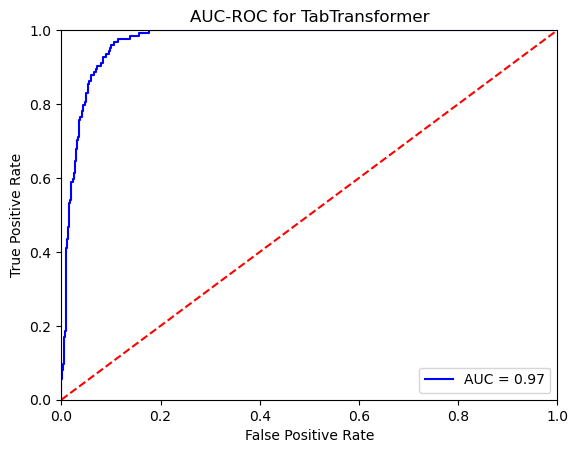

In [137]:
### Evaluating the model on the same test dataset that we had suring stage 1(a few weeks back) for all other models

for col in Y_val.columns[:]:
    print('Printing results for ',col.replace('\n',''))
    actuals = Y_val[col]
    preds = y_hat_labels[col]
    #print(actuals)
    #print(preds)
    f1 = f1_score(actuals,preds)
    precision = precision_score(actuals,preds)
    recall = recall_score(actuals,preds)
    accuracy = accuracy_score(actuals, preds)
    print(f'F1 Score : {f1}, Precision : {precision}, Recall : {recall}, Accuracy : {accuracy}')

print('*'*100)
print('Printing Results For All Labels Combined...')
actuals = Y_val.stack().values
preds = y_hat_labels.stack().values
#print(actuals)
#print(preds)
f1 = f1_score(actuals,preds)
precision = precision_score(actuals,preds)
recall = recall_score(actuals,preds)
accuracy = accuracy_score(actuals, preds)
print(f'F1 Score : {f1}, Precision : {precision}, Recall : {recall}, Accuracy : {accuracy}')

probs = y_hat.stack().values
fpr, tpr, threshold = sklearn.metrics.roc_curve(actuals, probs)
# print(len(fpr),len(tpr),len(threshold))
roc_auc = sklearn.metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title(f'AUC-ROC for TabTransformer')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Code ends here

In [75]:
# Probability Distribution Of Predicted Values BEFORE Implementing Class Weights 

pd.DataFrame(y_hat).describe()

,0,1,2,3,4,5,6,7
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,0.310236,0.308740,0.320185,0.300516,0.323239,0.291340,0.299247,0.299631
std,0.018310,0.018796,0.022429,0.015660,0.020792,0.017816,0.016359,0.016108
min,0.276965,0.282198,0.283236,0.278874,0.287528,0.263196,0.268981,0.272665
25%,0.297601,0.294224,0.303911,0.289724,0.309635,0.278355,0.287337,0.288586
50%,0.305068,0.303543,0.313356,0.296954,0.316957,0.287084,0.295840,0.296519
75%,0.318989,0.319847,0.329614,0.307485,0.330656,0.299967,0.308041,0.309522
max,0.365376,0.367900,0.395372,0.356913,0.387490,0.350941,0.349027,0.347511
